In [73]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
plt.style.use("Solarize_Light2")

In [74]:
churn_data = pd.read_csv('/home/elliot/PycharmProjects/CSC 495 - Telecom Customer Churn/Datasets/telecom_churn_Processed.csv')

X = churn_data.drop('Churn', axis=1)
y = churn_data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 42)

sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

### First Iteration:

In [75]:
xg = XGBClassifier()
xg.fit(X_train_sc, y_train)

y_pred_xg = xg.predict(X_test_sc)

y_pred_xg_train = xg.predict(X_train_sc)

xg_as = metrics.accuracy_score(y_test, y_pred_xg)
xg_as_train = metrics.accuracy_score(y_train, y_pred_xg_train)

print(f"Accuracy score of test data : {xg_as}")
print(f"Accuracy score of train data : {xg_as_train}")


[12:41:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy score of test data : 0.7811288237828522
Accuracy score of train data : 0.9828061982593929


<AxesSubplot:>

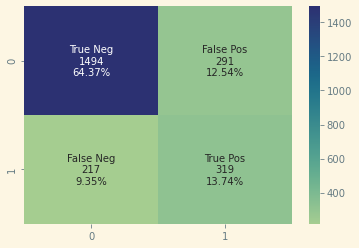

In [76]:
cf_matrix = metrics.confusion_matrix(y_pred_xg, y_test)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = [f"{value}" for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='crest')

In [77]:
print(metrics.classification_report(y_test, y_pred_xg))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1711
           1       0.60      0.52      0.56       610

    accuracy                           0.78      2321
   macro avg       0.72      0.70      0.71      2321
weighted avg       0.77      0.78      0.78      2321



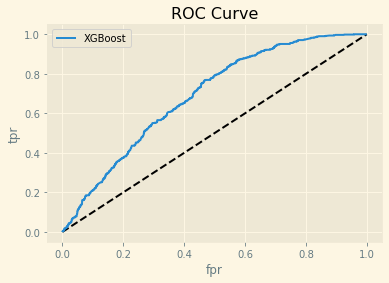

In [78]:
y_proba = xg.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_proba)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label = 'XGBoost')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve')
plt.legend();


On our first iteration of the XGBoost model we've gotten decent metrics, with an overall accuracy of 0.78, the positive
churn prediction recall is 0.52, hopefully we can improve these numbers after tuning the hyperparameters of our model.


#### Second Iteration:

In [79]:
parameters = {'learning_rate' : [0.01, 0.03, 0.05], 'max_depth' : [1, 4, 6], 'n_estimators' : [100, 300, 400, 600]}


In [80]:
xg_grid = GridSearchCV(XGBClassifier(), parameters, cv = 5)


In [81]:
xg_gridcv = XGBClassifier(learning_rate = .05, max_depth = 1, n_estimators = 600)

xg_gridcv.fit(X_train_sc, y_train)

y_pred_xggrid = xg_gridcv.predict(X_test_sc)
y_pred_xggrid_train = xg_gridcv.predict(X_train_sc)

xg_as_grid = metrics.accuracy_score(y_test, y_pred_xggrid)
xg_as_grid_train = metrics.accuracy_score(y_train, y_pred_xggrid_train)

print(f"Accuracy score of test data : {xg_as_grid}")
print(f"Accuracy score of train data : {xg_as_grid_train}")


[12:41:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy score of test data : 0.8069797501077122
Accuracy score of train data : 0.8104436425387391


<AxesSubplot:>

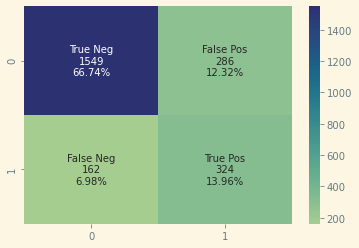

In [82]:
cf_matrix = metrics.confusion_matrix(y_pred_xggrid, y_test)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = [f"{value}" for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='crest')

In [83]:
print(metrics.classification_report(y_test, y_pred_xggrid))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1711
           1       0.67      0.53      0.59       610

    accuracy                           0.81      2321
   macro avg       0.76      0.72      0.73      2321
weighted avg       0.80      0.81      0.80      2321



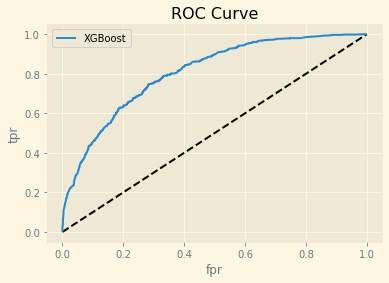

In [84]:
y_proba = xg_gridcv.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_proba)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label = 'XGBoost')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve')
plt.legend();

There was a decent boost in overall accuracy after hyperparameter tuning, moving from 0.78 to 0.81, and we had a slight
improvement in positive churn prediction recall.